Setup

In [1]:
!cat ~/.keras/keras.json

{
    "epsilon": 1e-07, 
    "floatx": "float32", 
    "image_data_format": "channels_last", 
    "backend": "tensorflow"
}

In [2]:
from google.colab import drive
drive.mount('/drive/')

import sys
sys.path.append('/drive/MyDrive/pyimagesearch/utils')

%cd /drive/MyDrive/pyimagesearch 
%pwd

Mounted at /drive/
/drive/MyDrive/pyimagesearch


'/drive/MyDrive/pyimagesearch'

In [3]:
from SimplePreprocessor import SimplePreprocessor
from SimpleDatasetLoader import SimpleDatasetLoader
from ImageToArrayPreprocessor import ImageToArrayPreprocessor

Shallownet

In [13]:
from keras.models import Sequential
from keras.layers.convolutional import Conv2D
from keras.layers.core import Activation
from keras.layers.core import Flatten
from keras.layers.core import Dense
from keras import backend as K

In [14]:
class ShallowNet:
	@staticmethod
	def build(width, height, depth, classes):
		# initialize the model along with the input shape to be
		# "channels last"
		model = Sequential()
		inputShape = (height, width, depth)

		# if we are using "channels first", update the input shape
		if K.image_data_format() == "channels_first":
			inputShape = (depth, height, width)

		# define the first (and only) CONV => RELU layer
		model.add(Conv2D(32, (3, 3), padding="same",
			input_shape=inputShape))
		model.add(Activation("relu"))

		# softmax classifier
		model.add(Flatten())
		model.add(Dense(classes))
		model.add(Activation("softmax"))

		# return the constructed network architecture
		return model

Train

In [15]:
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from keras.optimizers import SGD
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np

In [18]:
def train_shallownet(dataset_filepath, model_filepath):
    # grab the list of images that we'll be describing
    print("[INFO] loading images...")
    imagePaths = list(paths.list_images(dataset_filepath))

    # initialize the image preprocessors
    sp = SimplePreprocessor(32, 32)
    iap = ImageToArrayPreprocessor()

    # load the dataset from disk then scale the raw pixel intensities
    # to the range [0, 1]
    sdl = SimpleDatasetLoader(preprocessors=[sp, iap])
    (data, labels) = sdl.load(imagePaths, verbose=500)
    data = data.astype("float") / 255.0

    # partition the data into training and testing splits using 75% of
    # the data for training and the remaining 25% for testing
    (trainX, testX, trainY, testY) = train_test_split(data, labels, test_size=0.25, random_state=42)

    # convert the labels from integers to vectors
    trainY = LabelBinarizer().fit_transform(trainY)
    testY = LabelBinarizer().fit_transform(testY)

    # initialize the optimizer and model
    print("[INFO] compiling model...")
    opt = SGD(lr=0.005)
    model = ShallowNet.build(width=32, height=32, depth=3, classes=3)
    model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

    # train the network
    print("[INFO] training network...")
    H = model.fit(trainX, trainY, validation_data=(testX, testY), batch_size=32, epochs=100, verbose=1)

    # save the network to disk
    print("[INFO] serializing network...")
    model.save(model_filepath)

    # evaluate the network
    print("[INFO] evaluating network...")
    predictions = model.predict(testX, batch_size=32)
    print(classification_report(testY.argmax(axis=1), predictions.argmax(axis=1), target_names=["cat", "dog", "panda"]))

    # plot the training loss and accuracy
    plt.style.use("ggplot")
    plt.figure()
    plt.plot(np.arange(0, 100), H.history["loss"], label="train_loss")
    plt.plot(np.arange(0, 100), H.history["val_loss"], label="val_loss")
    plt.plot(np.arange(0, 100), H.history["accuracy"], label="train_accuracy")
    plt.plot(np.arange(0, 100), H.history["val_accuracy"], label="val_accuracy")
    plt.title("Training Loss and Accuracy")
    plt.xlabel("Epoch #")
    plt.ylabel("Loss/Accuracy")
    plt.legend()
    plt.show()

[INFO] loading images...
[INFO] processed 500/3000
[INFO] processed 1000/3000
[INFO] processed 1500/3000
[INFO] processed 2000/3000
[INFO] processed 2500/3000
[INFO] processed 3000/3000
[INFO] compiling model...
[INFO] training network...
Epoch 1/100
71/71 [==============================] - 2s 25ms/step - loss: 1.0756 - accuracy: 0.4146 - val_loss: 0.9176 - val_accuracy: 0.5800
Epoch 2/100
71/71 [==============================] - 2s 23ms/step - loss: 0.9147 - accuracy: 0.5607 - val_loss: 1.0036 - val_accuracy: 0.5027
Epoch 3/100
71/71 [==============================] - 2s 23ms/step - loss: 0.9066 - accuracy: 0.5375 - val_loss: 0.9458 - val_accuracy: 0.5413
Epoch 4/100
71/71 [==============================] - 2s 25ms/step - loss: 0.8655 - accuracy: 0.5720 - val_loss: 0.8414 - val_accuracy: 0.6187
Epoch 5/100
71/71 [==============================] - 2s 23ms/step - loss: 0.8467 - accuracy: 0.5879 - val_loss: 0.8508 - val_accuracy: 0.5987
Epoch 6/100
71/71 [==============================] 

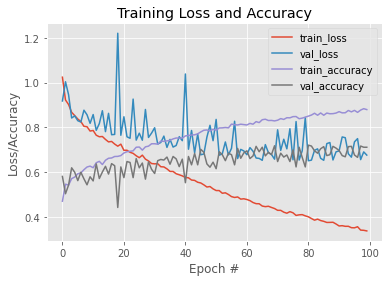

In [19]:
train_shallownet(dataset_filepath="/drive/MyDrive/pyimagesearch/datasets/animals", model_filepath="/drive/MyDrive/pyimagesearch/output/shallownet_weights.hdf5")

Load

In [20]:
from keras.models import load_model
from imutils import paths
import numpy as np
import cv2
from matplotlib import pyplot as plt 

In [21]:
def load_shallownet(dataset_filepath, model_filepath):
    # initialize the class labels
    classLabels = ["cat", "dog", "panda"]

    # grab the list of images in the dataset then randomly sample
    # indexes into the image paths list
    print("[INFO] sampling images...")
    imagePaths = np.array(list(paths.list_images(dataset_filepath)))
    idxs = np.random.randint(0, len(imagePaths), size=(10,))
    imagePaths = imagePaths[idxs]

    # initialize the image preprocessors
    sp = SimplePreprocessor(32, 32)
    iap = ImageToArrayPreprocessor()

    # load the dataset from disk then scale the raw pixel intensities
    # to the range [0, 1]
    sdl = SimpleDatasetLoader(preprocessors=[sp, iap])
    (data, labels) = sdl.load(imagePaths)
    data = data.astype("float") / 255.0

    # load the pre-trained network
    print("[INFO] loading pre-trained network...")
    model = load_model(model_filepath)

    # make predictions on the images
    print("[INFO] predicting...")
    preds = model.predict(data, batch_size=32).argmax(axis=1)

    # loop over the sample images
    for (i, imagePath) in enumerate(imagePaths):
        # load the example image, draw the prediction, and display it
        # to our screen
        image = cv2.imread(imagePath)
        cv2.putText(image, "Label: {}".format(classLabels[preds[i]]),
            (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)
        plt.figure()
        plt.axis("off")
        plt.title("Image")
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

[INFO] sampling images...
[INFO] loading pre-trained network...
[INFO] predicting...


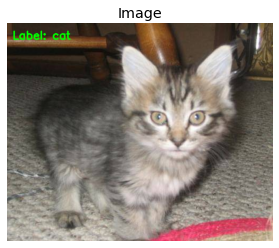

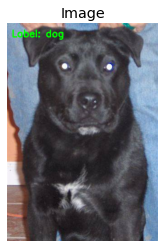

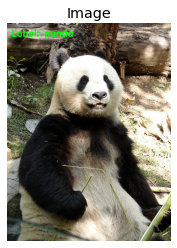

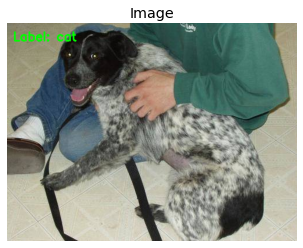

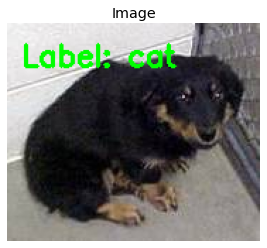

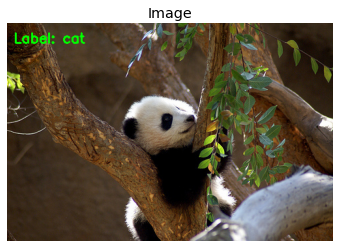

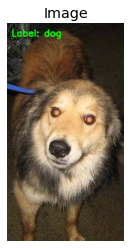

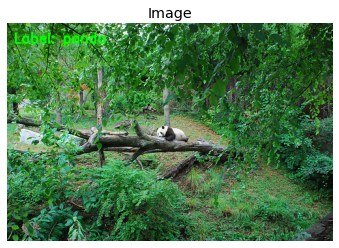

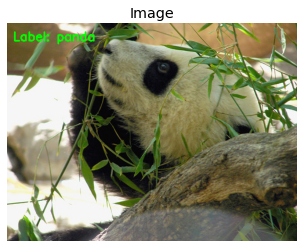

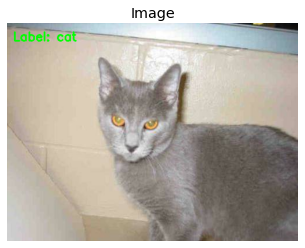

In [22]:
load_shallownet(dataset_filepath="/drive/MyDrive/pyimagesearch/datasets/animals", model_filepath="/drive/MyDrive/pyimagesearch/output/shallownet_weights.hdf5")